In [3]:
# Inserção/instalação dos pacotes para lista 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from pmdarima.utils import tsdisplay
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels

### 1) Considere a série Taxa de crescimento trimestral do produto nacional bruto real dos EUA (*quarterly growth rate of the U.S. real gross national product*  - GNP), do segundo trimestre de 1947 ao primeiro trimestre de 1991. (Fonte: R.S. TSAY - *Analysis of Financial Time Series* 2nd Ed).

In [4]:
# Inicialização do Exercício 1
gnp = pd.read_csv('./dados/dgnp82.txt',header=None, names=["data"])
gnp['time'] = pd.date_range('1947-01', periods=len(gnp['data']), freq='QS') #Cria escala de tempo trimestral (quarters)
gnp = gnp.set_index('time') #Cría índice temporal
gnp.head()

,data
time,
1947-01-01,0.00632
1947-04-01,0.00366
1947-07-01,0.01202
1947-10-01,0.00627
1948-01-01,0.01761


#### 1.a) Verifique se a série é estacionária. Comprove com o teste de Dickey Fuller aumentado, justificando a escolha da defasagem.

In [5]:
# Teste de Dickey-Fuller aumentado com drift+trend
adf_uscon_trend = adfuller(gnp.data, regression='ct')
print(f'ADF Statistic: {adf_uscon_trend[0]}')
print(f'p-value: {adf_uscon_trend[1]}')
for key, value in adf_uscon_trend[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.853823961109995
p-value: 7.784841687350055e-13
Critial Values:
   1%, -4.011455293061225
Critial Values:
   5%, -3.4358815193469385
Critial Values:
   10%, -3.141957196268222


**Como a estatística é menor do que o tau crítico para os valores críticos, e o p-valor é (muito) menor que 1%, rejeitamos a hipótese nula e aceitamos que a série não possui raiz unitária e é estacionária**

TODO: justificar defasagem

#### 1.b) Faça os gráficos das funções de autocorrelação e autocorrelação parcial da série. O que se pode inferir sobre a ordem do modelo? Justifique!

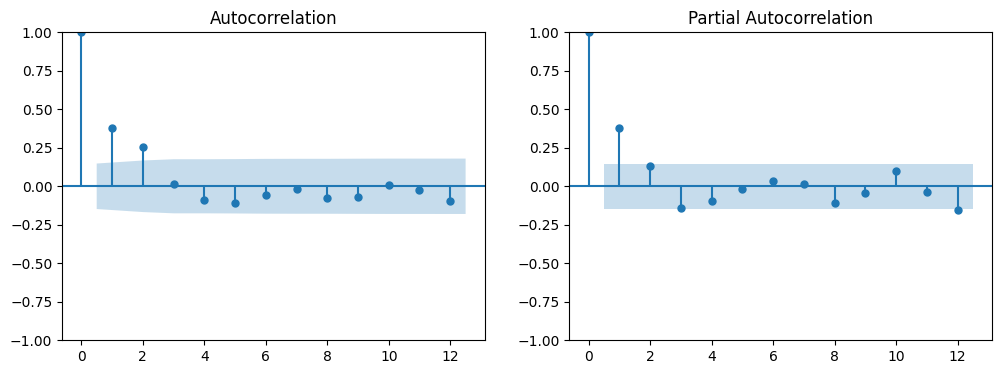

In [7]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
fig = statsmodels.graphics.tsaplots.plot_acf(gnp.data, lags=12, ax=ax1)
ax2 = fig.add_subplot(122)
fig = statsmodels.graphics.tsaplots.plot_pacf(gnp.data, lags=12, ax=ax2)
plt.show()

**Podemos observar uma correlação entre a observação e até 2 atrasos, corroborada pela função de autocorrelação parcial. Assim, a ordem do modelo parecer ser MA(2) ou AR(2)**

TODO: verificar diferenca autocorrelacao e autoc. parcial

#### 1.c) Gere, com os dados da série, modelos ARMA(p, q), p = 0, 1, 2, 3 ; q = 0, 1, 2, 3, exceto com p = q = 0. Faça uma tabela com os 15 valores encontrados, considerando o p-value do teste de independência do resíduo do modelo e o critério AICc. Com base na tabela, escolha o melhor modelo dentre os testados. Faça a análise gráfica do resultado.


In [46]:
from sklearn.model_selection import train_test_split
gnp_train, gnp_test = train_test_split(gnp, test_size=0.1/3, shuffle=False)
gnp_test

,data
time,
1989-07-01,0.00085
1989-10-01,0.00420
1990-01-01,0.00108
1990-04-01,0.00358
1990-07-01,-0.00399
1990-10-01,-0.00650


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  170
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 544.294
Date:                Sun, 30 Jul 2023   AIC                          -1080.587
Time:                        17:02:21   BIC                          -1068.044
Sample:                    01-01-1947   HQIC                         -1075.498
                         - 04-01-1989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.001      6.579      0.000       0.006       0.010
ma.L1          0.3051      0.069      4.430      0.000       0.170       0.440
ma.L2          0.2664      0.071      3.725      0.0

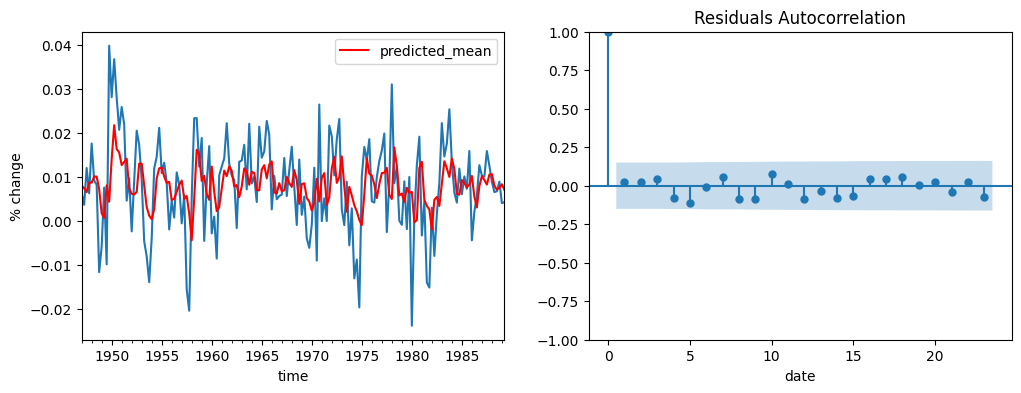

In [47]:
p = range(0,4)
q = range(0,4)
d = range(0,1)
pdq = list(itertools.product(p,d,q))
pq = [(p,d,q) for p,d,q in pdq if (p !=0 or q!=0)]

ARMA_aic = []
ARMA_pval = []

for param in pq:
    try:
        ARMA_ = ARIMA(gnp_train, order=param)
        res = ARMA_.fit()
        AUX = acorr_ljungbox(res.resid, lags=[10])
        ARMA_pval.append(AUX.lb_pvalue)
        ARMA_aic.append(res.aicc)
        if res.aicc <= min(ARMA_aic):
            BEST_param = param
    except Exception as e:
        print(e)
        print(f'Failed for param {param}')
        continue

#Gera tabela
data = {'AICc':  ARMA_aic,
        'Pval': ARMA_pval}

# df_ARMA = pd.DataFrame(data, index = pq).rename_axis('ARMA',axis=1)
# print(df_ARMA)
# Melhor modelo ARMA(BEST_param)
BEST_ARMA = ARIMA(gnp_train, order=(BEST_param))
res_BEST_ARMA = BEST_ARMA.fit()
print(res_BEST_ARMA.summary())

BEST_ARMA_predict = pd.DataFrame(res_BEST_ARMA.predict())
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
gnp_train.data.plot(ax=ax1)
BEST_ARMA_predict.plot(ax=ax1,color='red')
plt.ylabel("% change");
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_acf(res_BEST_ARMA.resid,ax=ax2)
plt.xlabel("lags")
plt.title("Residuals Autocorrelation")
plt.xlabel("date")
plt.show()

Pvalor: 10    0.606295
Name: lb_pvalue, dtype: float64


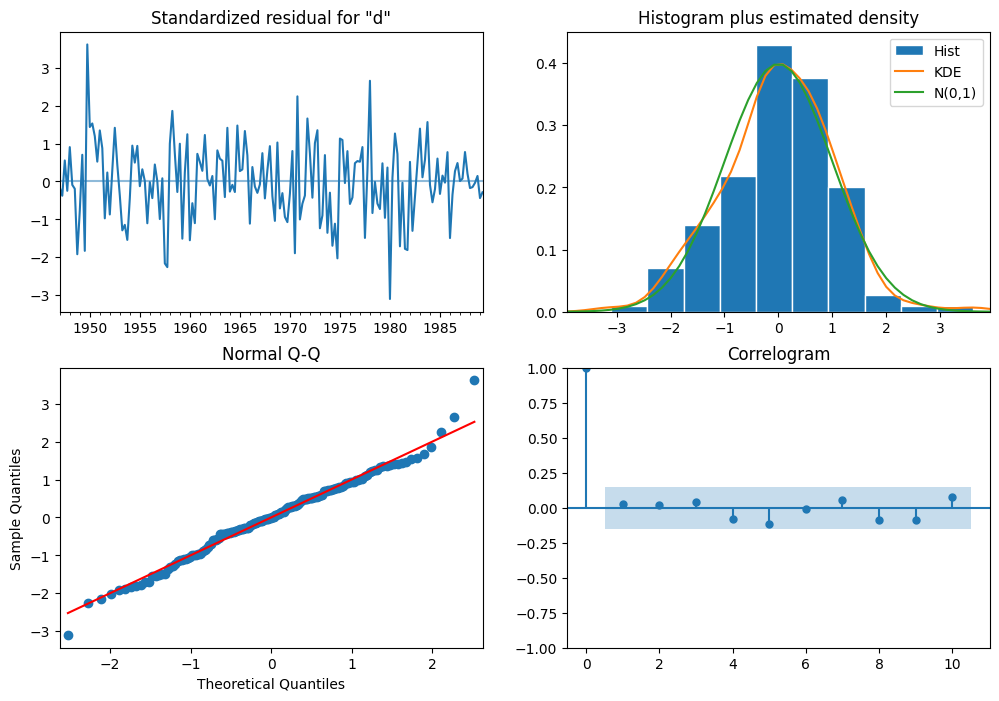

In [48]:
# Diagnóstico do resíduo do modelo
AUX = acorr_ljungbox(res_BEST_ARMA.resid, lags=[10])
AUX_Pval = AUX.lb_pvalue
print(f'Pvalor: {AUX_Pval}')
res_BEST_ARMA.plot_diagnostics(figsize=(12,8))
plt.show()

#### 1.d) Obtenha as previsões da série até cinco passos à frente com o melhor modelo obtido no item 1.c). Mostre o gráfico das previsões com intervalo de confiança de 95%.

Forecast ARMA  (0, 0, 2) :
 data            mean   mean_se  mean_ci_lower  mean_ci_upper
1989-07-01  0.005983  0.009836      -0.013295       0.025262
1989-10-01  0.007240  0.010284      -0.012916       0.027396
1990-01-01  0.007986  0.010612      -0.012814       0.028787
1990-04-01  0.007986  0.010612      -0.012814       0.028787
1990-07-01  0.007986  0.010612      -0.012814       0.028787
1990-10-01  0.007986  0.010612      -0.012814       0.028787
1991-01-01  0.007986  0.010612      -0.012814       0.028787
1991-04-01  0.007986  0.010612      -0.012814       0.028787
1991-07-01  0.007986  0.010612      -0.012814       0.028787
1991-10-01  0.007986  0.010612      -0.012814       0.028787
1992-01-01  0.007986  0.010612      -0.012814       0.028787
1992-04-01  0.007986  0.010612      -0.012814       0.028787
1992-07-01  0.007986  0.010612      -0.012814       0.028787
1992-10-01  0.007986  0.010612      -0.012814       0.028787
1993-01-01  0.007986  0.010612      -0.012814       0.028

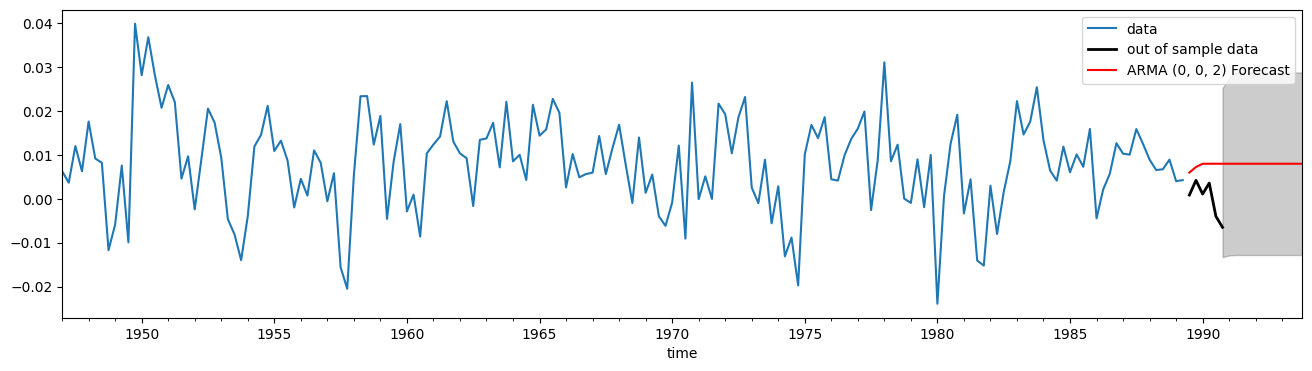

In [49]:
indice_5_frente = pd.date_range(gnp.data.index[-1], freq="Q", periods = 18) #Índice temporal para as previsões

fcast_BEST_ARMA = res_BEST_ARMA.get_forecast(18)
fcast_BEST_ARMA_mean = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean']
fcast_BEST_ARMA_low = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean_ci_lower']
fcast_BEST_ARMA_up = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean_ci_upper']
fcast_BEST_ARMA_mean = fcast_BEST_ARMA_mean.rename('ARMA '+str(BEST_param)+' Forecast')

## Imprime as previsões
print(f'Forecast ARMA ',BEST_param, ':\n',fcast_BEST_ARMA.summary_frame(alpha=0.05),'\n')

## Gráficos das previsões
fig, ax = plt.subplots(1,1,figsize=(16,4))
gnp_train.data.plot(ax=ax, legend=True)
gnp_test.data.plot(ax=ax, color='k', lw=2, label='out of sample data', legend=True)

fcast_BEST_ARMA_mean.plot(ax=ax,color='red', legend=True)
ax.fill_between(indice_5_frente, fcast_BEST_ARMA_low, fcast_BEST_ARMA_up, color='k',alpha=0.2);
plt.show()

### 2) Considere a série temporal logarítmica trimestral do produto interno bruto dos EUA (U.S. quarterly gross domestic product – GDP) desde o primeiro trimestre de 1947 até o quarto trimestre de 2003 (Fonte: R.S. TSAY - Analysis of Financial Time Series 2nd Ed). OBS: para análise, deve-se tomar o log da série original.

In [74]:
# Inicialização do Exercício 2
GDP = pd.read_csv('./dados/GDP.csv',header=None, names=["temp", "GDP"])
GDP['GDP_log'] = np.log(GDP['GDP'])
GDP['time'] = pd.date_range('1947-01', periods=len(GDP['GDP']), freq='QS') #Cria escala de tempo trimestral (quarters)
GDP = GDP.set_index('time') #Cría índice temporal
GDP.drop('temp', inplace=True, axis=1)
GDP.drop('GDP', inplace=True, axis=1)
GDP.head()

,GDP_log
time,
1947-01-01,5.468904
1947-04-01,5.482720
1947-07-01,5.499624
1947-10-01,5.538908
1948-01-01,5.562219


##2.a) Verifique se a série resultante é estacionária. Comprove com o teste de Dickey Fuller aumentado, justificando a escolha da defasagem.

##2.b) Determine um modelo ARIMA para a série resultante. Faça o gráfico comparando os dados da série resultante com os valores ajustados com o modelo.

##2.c) Apresente as previsões de 1 a 10 passos à frente com o esse melhor modelo. Mostre o gráfico da previsão com intervalo de confiança de 95%.

#3) Considere a série Venda mensal de medicamentos cortezaesteróides na Austrália de 1992 a 2008 (h02), disponível eletronicamente em: https://www.otexts.org/fpp2

In [ ]:
# Inicialização do Exercício 1
data = pd.read_csv('h02.csv')
data.drop('time', inplace=True, axis=1)
data.drop('Unnamed: 0', inplace=True, axis=1)
data['time'] = pd.date_range('1991-07', periods=len(data['value']), freq='MS') #Cria escala de tempo trimestral (quarters)
data = data.set_index('time') #Cría índice temporal
data.head()

##3.a) Verifique se a séria apresenta raiz unitária e sazonalidade. O que pode ser inferido sobre a sazonalidade?

##3.b) Obtenha um modelo ARIMA(p,0,q)(P,1,Q)[S] adequado para a série. Considere pmax = qmax = 3, Pmax = Qmax = 2. Justifique a escolha. Apresente os coeficientes do modelo.

##3.c) Apresente as previsões de 1 a 12 passos à frente com o esse melhor modelo. Mostre o gráfico da previsão com intervalo de confiança de 95%.

#4) Considere a série de retornos logaritmos do índice PETR4.SA 07/01/2013 a 23/12/2016.

In [ ]:
ticket = 'PETR4.SA'
data_inicio = '2013-01-07'
data_fim    = '2016-12-23'
dados = yf.download(ticket, start=data_inicio, end=data_fim)
# Cálculo do retorno logarítmico
dados['Return'] = np.log(dados['Adj Close'] / dados['Adj Close'].shift(1))
dados = dados.dropna()
tsdisplay(dados['Return'])
dados.head()

#4.a) Verifique se há heteroscedasticidade. Justifique!

##4.b) Obtenha os seguintes modelos para a volatilidade: EWMA com  = 0.96, ARCH(1), ARCH(10), GARCH(1,1), EGARCH(1,1) e GJR-GARCH(1,1). Faca o gráfico da série de retornos juntamente com a curva do desvio padrão condicional gerado para cada modelo. Apresente também as expressões dos modelos obtidos.

##Com os modelos ARCH(10) e GARCH(1,1), apresente as previsões da volatilidade (desvio padrão) condicional com horizonte de previsão h = 200. Apresente o gráfico das previsões e verifique que, para $h \rightarrow \infty$ [h tendendo ao infinito], as previsões convergem para os desvios padrões incondicionais dos modelos de volatilidade utilizados.